## LSTM Autoencoderで異常検知(pytorch)

In [1]:
%load_ext lab_black

In [2]:
# ライブラリのインポート
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import LambdaLR

import time
import argparse
import warnings

warnings.simplefilter("ignore")

In [3]:
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

qtdb/sel102 ECG dataset [2] という心電図データ

http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt


In [4]:
df = pd.read_csv("../../data/qtdbsel102.txt", header=None, delimiter="\t")
df.head()

,0,1,2
0,200.000,4.770,2.100
1,200.004,4.820,2.135
2,200.008,4.805,2.190
3,200.012,4.750,2.285
4,200.016,4.710,2.440


傾向の確認

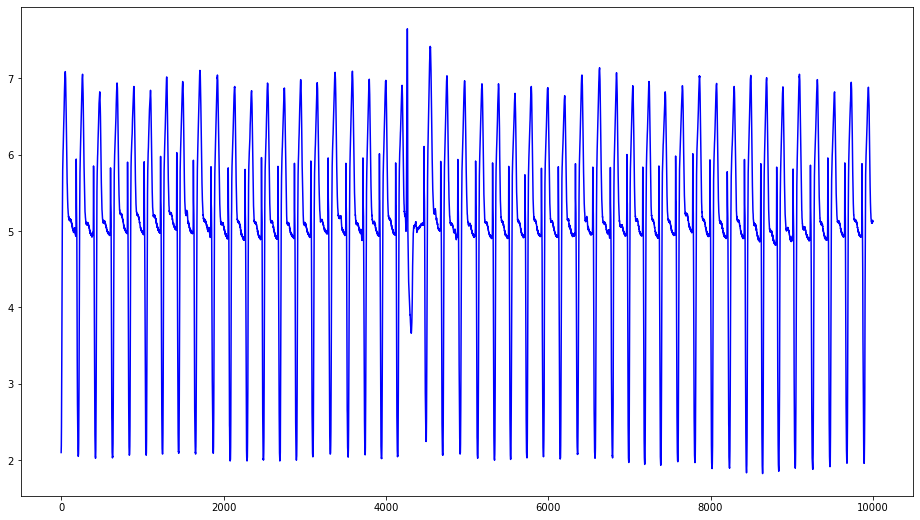

In [5]:
ecg_dataset = df.iloc[:, 2].values
ecg_dataset = ecg_dataset[:10000]
ecg_dataset = ecg_dataset.reshape(len(ecg_dataset), -1)

plt.figure(figsize=(16, 9))
plt.plot(ecg_dataset, color="b")
plt.show()

異常箇所の確認

<Figure size 432x288 with 0 Axes>

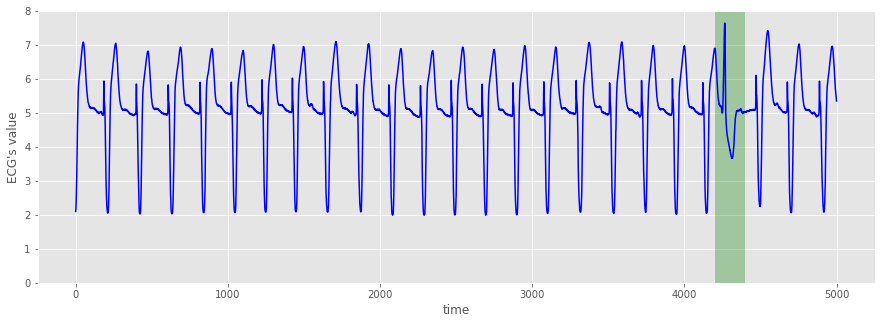

In [6]:
plt.figure()

plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.xlabel("time")
plt.ylabel("ECG's value")
plt.plot(np.arange(5000), ecg_dataset[:5000], color="b")
plt.ylim(0, 8)
x = np.arange(4200, 4400)
y1 = [0] * len(x)
y2 = [8] * len(x)
plt.fill_between(x, y1, y2, facecolor="g", alpha=0.3)
plt.show()

データセットを正規化し、学習データとテストデータに分割

In [7]:
# 平均値を0にする
ecg_dataset_mean = ecg_dataset.mean()
ecg_dataset = ecg_dataset - ecg_dataset_mean

# データセットの最大値で割り、-1～1の範囲に収まるように正規化する
ecg_dataset_max = np.abs(ecg_dataset).max()
ecg_dataset = ecg_dataset / ecg_dataset_max

In [8]:
train_data = ecg_dataset[5000:10000]
test_data = ecg_dataset[:5000]

In [9]:
print(train_data.shape, test_data.shape)

(5000, 1) (5000, 1)


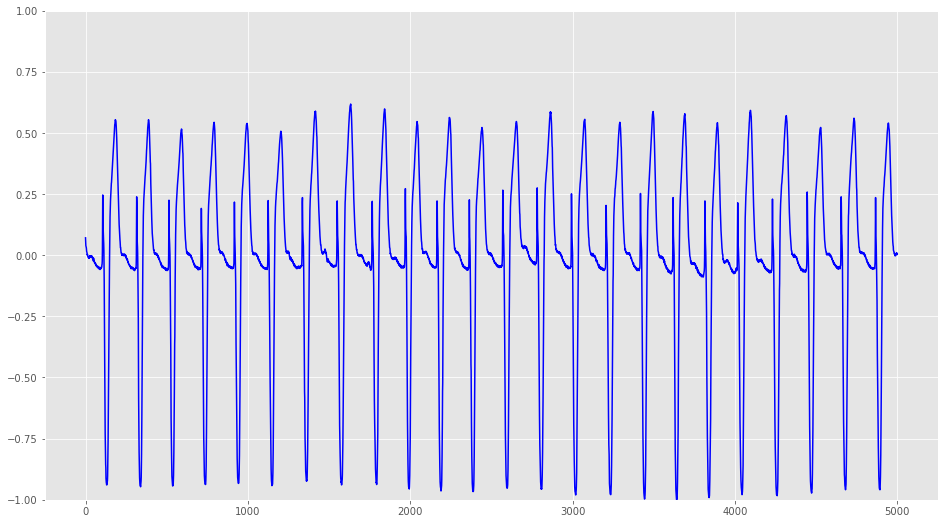

In [10]:
# 学習データプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(train_data, color="b")
plt.show()

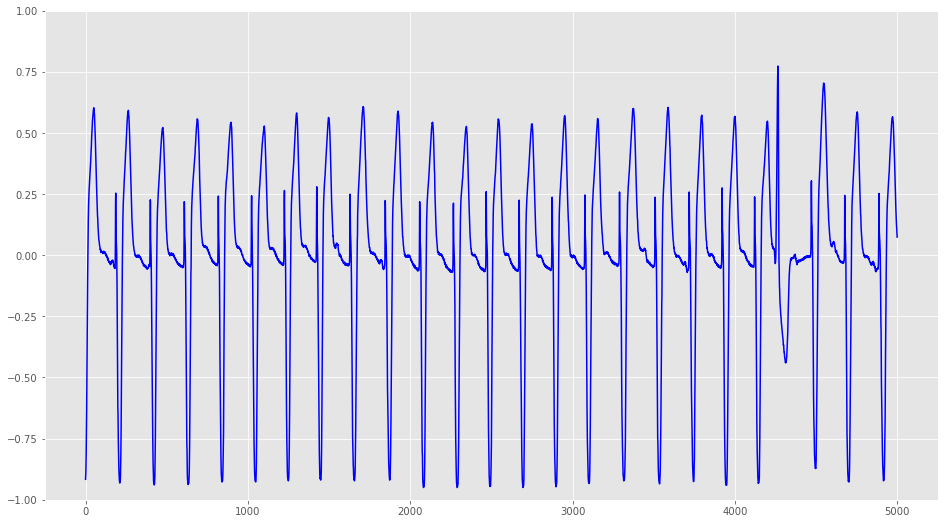

In [11]:
# テストデータプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(test_data, color="b")
plt.show()

#### Modeling(Autoencoder LSTM)

In [12]:
train_data, valid_data = train_test_split(
    train_data, test_size=0.2, random_state=RANDOM_SEED
)

In [13]:
train_sequence = train_data.astype(np.float32).tolist()
val_sequence = valid_data.astype(np.float32).tolist()
test_sequence = test_data.astype(np.float32).tolist()

In [14]:
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1) for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape  # n_seq,1,1
    return dataset, seq_len, n_features

In [15]:
train_dataset, seq_len, n_features = create_dataset(train_sequence)
val_dataset, _, _ = create_dataset(val_sequence)
test_dataset, _, _ = create_dataset(test_sequence)

In [16]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = 2 * args.embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True  # True = (batch_size, seq_len, n_features)
            # False = (seq_len, batch_size, n_features)
            # default = false
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True,
        )

    def forward(self, x):
        # (4,1)
        x = x.reshape((args.batch_size, self.seq_len, self.n_features))
        # (batch, seq, feature)   #(1,1,1)
        x, (_, _) = self.rnn1(x)  # (1,1,256)
        x, (hidden_n, _) = self.rnn2(x)
        # x shape (1,1,128)
        # hidden_n (1,1,128)
        return hidden_n.reshape((self.n_features, args.embedding_dim))  # (1,128)

In [17]:
class Decoder(nn.Module):
    def __init__(self, seq_len, n_features):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim = 2 * args.embedding_dim
        self.n_features = n_features

        self.rnn1 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True,
        )
        self.rnn2 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        # x shape(1,128)
        x = x.repeat(self.seq_len, args.batch_size)  # (1, 128)

        x = x.reshape((n_features, self.seq_len, args.embedding_dim))  # 1,1,128
        x, (hidden_n, cell_n) = self.rnn1(x)  # (1,1,128)
        x, (hidden_n, cell_n) = self.rnn2(x)  # (1,1,256)
        x = x.reshape((self.seq_len, self.hidden_dim))  # (1,256)

        return self.output_layer(x)  # (1,1)

In [18]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features):
        super(RecurrentAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        self.encoder = Encoder(seq_len, n_features).to("cpu")
        self.decoder = Decoder(seq_len, n_features).to("cpu")

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x

In [19]:
def train_model(train_dataset, val_dataset, n_epochs):
    model = RecurrentAutoencoder(seq_len, n_features)
    model = model.to("cpu")

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    criterion = nn.L1Loss(reduction="sum").to("cpu")

    history = dict(train=[], val=[])

    for epoch in range(1, n_epochs + 1):
        model = model.train()
        ts = time.time()
        train_losses = []

        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to("cpu")
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to("cpu")
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                val_losses.append(loss.item())
        te = time.time()
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history["train"].append(train_loss)
        history["val"].append(val_loss)

        print(
            f"Epoch: {epoch}  train loss: {train_loss}  val loss: {val_loss}  time: {te-ts} "
        )

    return model.eval(), history

In [20]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ===== data loading ==== #
args.batch_size = 1

# ==== model capacity ==== #
args.n_layers = 1
args.embedding_dim = 128

# ==== regularization ==== #
args.dropout = 0
args.use_bn = False

# ==== optimizer & training  # ====
args.lr = 0.001
args.epoch = 100

# ==== Experiment Variable ==== #
model, history = train_model(train_dataset, val_dataset, args.epoch)

Epoch: 1  train loss: 0.03513130241708132  val loss: 0.01126095990248723  time: 168.16001629829407 
Epoch: 2  train loss: 0.02238739751157118  val loss: 0.016415569437667726  time: 107.4422538280487 
Epoch: 3  train loss: 0.016421042205765842  val loss: 0.01893345560110174  time: 133.8398675918579 
Epoch: 4  train loss: 0.015988843208018806  val loss: 0.010613624738063663  time: 148.1883726119995 
Epoch: 5  train loss: 0.015321197827579453  val loss: 0.00794508950470481  time: 171.41678261756897 
Epoch: 6  train loss: 0.012993395935438457  val loss: 0.00979397739446722  time: 163.38063383102417 
Epoch: 7  train loss: 0.013579688063371577  val loss: 0.009022336702502798  time: 433.9210867881775 
Epoch: 8  train loss: 0.012622112834142172  val loss: 0.007702235728269443  time: 129.82442164421082 
Epoch: 9  train loss: 0.012327469418480178  val loss: 0.008774972009006888  time: 112.80935740470886 
Epoch: 10  train loss: 0.01160710302181542  val loss: 0.010142075255222153  time: 63.3512172

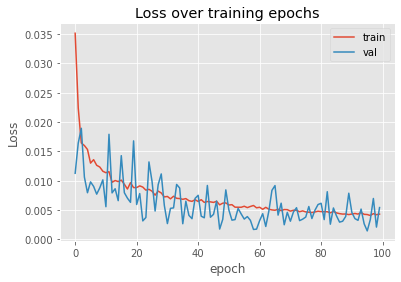

In [21]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.title("Loss over training epochs")
plt.legend(["train", "val"])
plt.show()

In [22]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction="sum").to("cpu")
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to("cpu")
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

<AxesSubplot:ylabel='Density'>

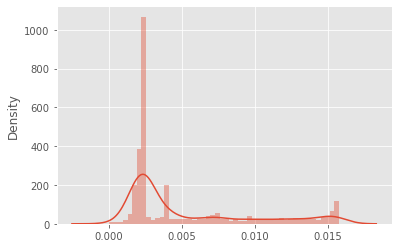

In [23]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True)

<AxesSubplot:ylabel='Density'>

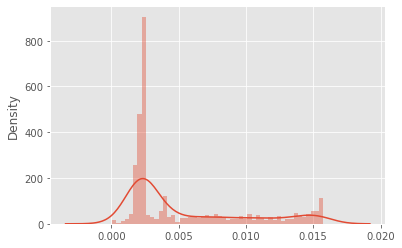

In [24]:
_, losses = predict(model, val_dataset)
sns.distplot(losses, bins=50, kde=True)

In [29]:
THRESHOLD = 0.016

<AxesSubplot:ylabel='Density'>

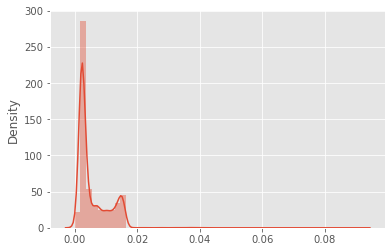

In [30]:
predictions, pred_losses = predict(model, test_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [31]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f"Correct normal predictions: {correct}/{len(test_dataset)}")

Correct normal predictions: 4981/5000
